In [1]:
import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from imgtools import *

In [2]:
image_path ='meo_con.jpg' 
img = cv.imread(image_path)
h,w,channels = img.shape
print(f'Number of rows(height): ',h)
print(f'Number of column(weight): ',w)
print(f'Number of channels: ',channels)


Number of rows(height):  6016
Number of column(weight):  4016
Number of channels:  3


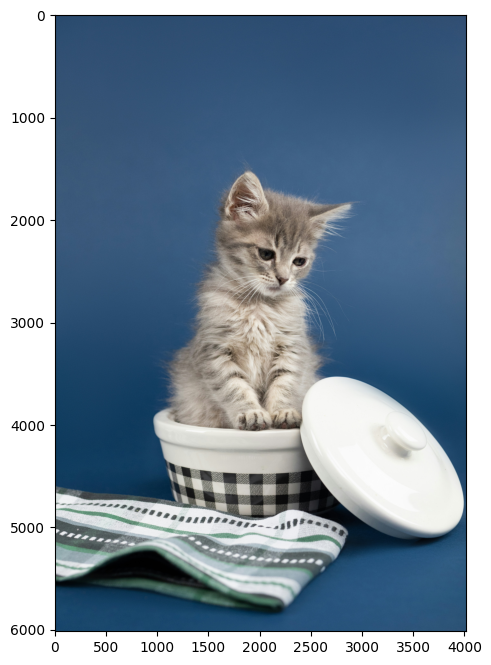

In [3]:
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.figure(figsize=(12,8))
plt.imshow(img_rgb)
plt.show()

# WATERSHED ALGORITHM

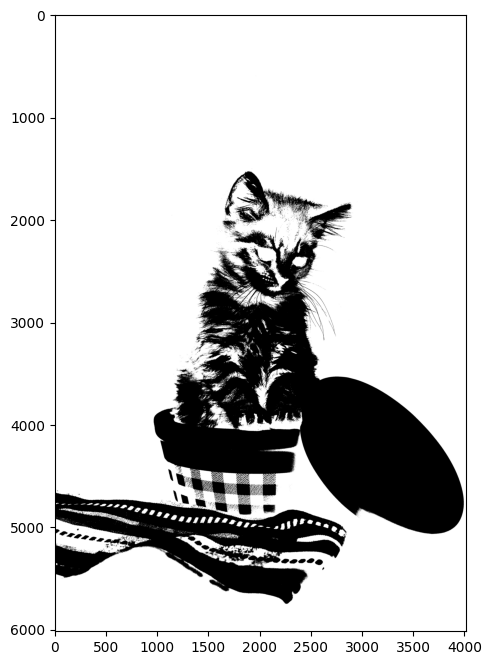

In [4]:
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# Using the thresholding to create the distance photo area and feature
ret, bin_img = cv.threshold(img_gray, 127, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
plt.figure(figsize=(12,8))
plt.imshow(cv.cvtColor(bin_img, cv.COLOR_BGR2RGB))
plt.show()

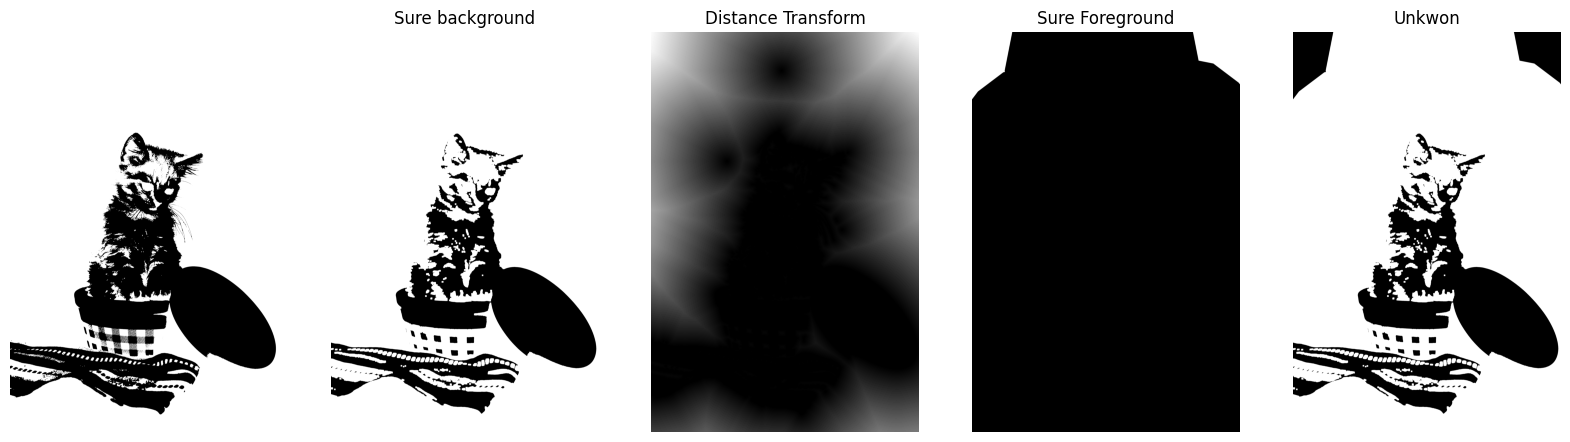

In [5]:
# Noise Removal
kernel = np.ones((3,3), np.uint8)
bin_img = cv.morphologyEx(bin_img, cv.MORPH_OPEN, kernel, iterations=2)

# Sure background area
sure_bg = cv.dilate(bin_img, kernel, iterations=9)

# Distance transform
dist_tranform = cv.distanceTransform(bin_img, cv.DIST_L2, 5)

# Foreground area
ret, sure_fg = cv.threshold(dist_tranform, 0.7*dist_tranform.max(), 255,0)
sure_fg = np.uint8(sure_fg)

# Unknown area
unknown = cv.subtract(sure_bg, sure_fg)

fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(20,10))
axes[0].imshow(bin_img, cmap='gray')
axes[0].axis('off')
axes[1].imshow(sure_bg, cmap='gray')
axes[1].set_title('Sure background')
axes[1].axis('off')
axes[2].imshow(dist_tranform, cmap='gray')
axes[2].set_title('Distance Transform')
axes[2].axis('off')
axes[3].imshow(sure_fg, cmap='gray')
axes[3].set_title('Sure Foreground')
axes[3].axis('off')
axes[4].imshow(unknown, cmap='gray')
axes[4].set_title('Unkwon')
axes[4].axis('off')
plt.show()

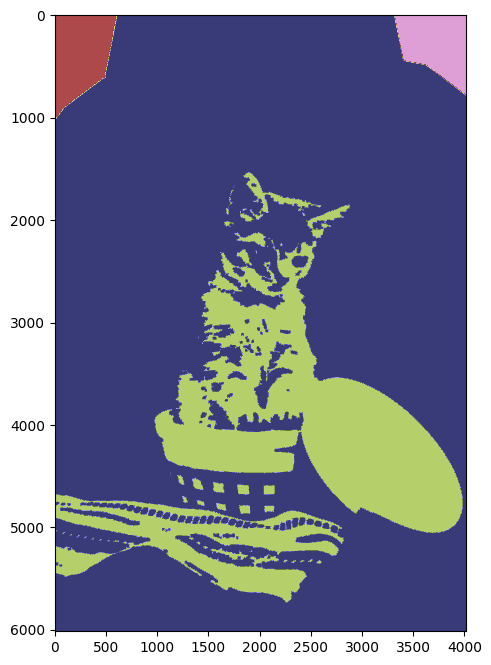

In [6]:
# Market labelling
ret, markers = cv.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0 but 1
markers = markers+1
# Mark the region of unknown with zero
markers[unknown==255]=0
plt.figure(figsize=(12,8))
plt.imshow(markers, cmap='tab20b')
plt.show()

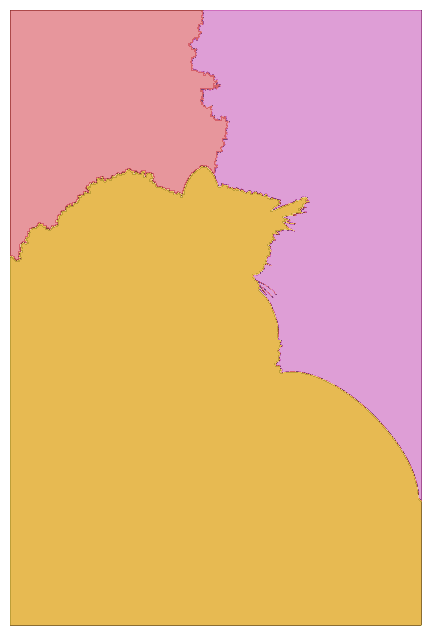

In [7]:
# Apply Watershed Algorithm
markers = cv.watershed(img, markers)
plt.figure(figsize=(12,8))
plt.imshow(markers, cmap='tab20b')
plt.axis('off')
plt.show()

(-0.5, 4015.5, 6015.5, -0.5)

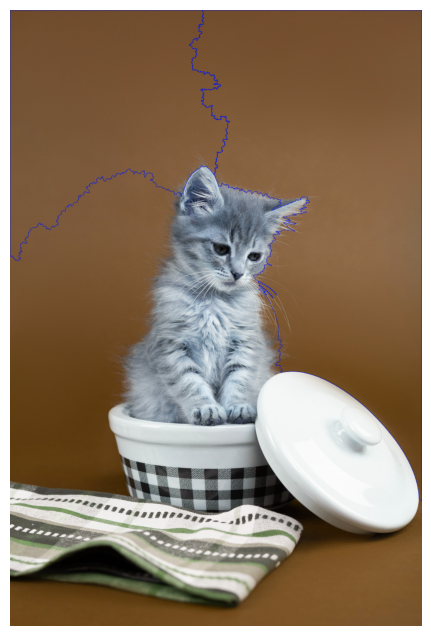

In [8]:
labels = np.unique(markers)
animal = []
for label in labels[2:]:
    target = np.where(markers==label, 255, 0).astype(np.uint8)
    contours, hierarchy = cv.findContours(target, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    animal.append(contours[0])
# Draw the outline
img = cv.drawContours(img, animal,-1,color=(0,23,233), thickness=2)
plt.figure(figsize=(12,8))
plt.imshow(img)
plt.axis('off')


# GRABCUT ALGORITHM

In [9]:
img = img.copy()

In [10]:
mask = np.zeros(img.shape[:2], np.uint8)
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [11]:
# Create arrays to store background and foreground models
backgroundmodel = np.zeros((1,65), np.float64)
foregroundmodel = np.zeros((1,65), np.float64)
#as the coordinates of the rectangle
# where the values are entered as
# (startingPoint_x, startingPoint_y, width, height)
# these coordinates are according to the input image
# it may vary for different images
rectangle = (70,39,2600,4100)

In [12]:
# apply the grabcut algorithm with appropriate
cv.grabCut(img, mask, rectangle, backgroundmodel, foregroundmodel, 5, cv.GC_INIT_WITH_RECT)

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 array([[1.51991626e-01, 2.35063962e-01, 3.83826733e-01, 1.53424550e-01,
         7.56931293e-02, 2.33376899e+02, 2.35459993e+02, 2.34418835e+02,
         1.33746061e+02, 9.82931620e+01, 6.50758800e+01, 1.10476275e+02,
         7.40796511e+01, 3.39915072e+01, 1.50068544e+02, 1.51304092e+02,
         1.39696693e+02, 3.98116460e+01, 3.46180280e+01, 3.31814248e+01,
         1.88049187e+02, 1.64964302e+02, 1.67784411e+02, 1.64964302e+02,
         1.57038189e+02, 1.62903977e+02, 1.67784411e+02, 1.62903977e+02,
         1.71916341e+02, 8.06690428e+01, 7.19624362e+01, 6.66309374e+01,
         7.19624362e+01, 6.95349940e+01, 6.86605510e+01, 6.66309374e+01,
         6.86605510e+01, 7.45749028e+01, 1.57112727e+02, 1.35627950e+02,
         1.44943407e+02, 1.35627950e+02, 1.1

In [13]:
# Create a binary mask where pixels classified as background or probable background are set to 0, others to 1
mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img_segment = img*mask2[:,:,np.newaxis]

(-0.5, 4015.5, 6015.5, -0.5)

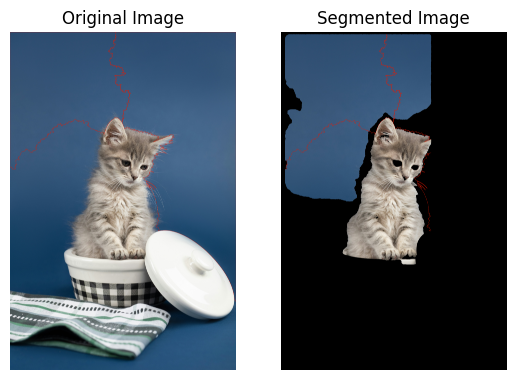

In [14]:
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.axis('off')
# Display the segmented image
plt.subplot(1, 2, 2)
plt.title('Segmented Image')
plt.imshow(cv.cvtColor(img_segment, cv.COLOR_BGR2RGB))
plt.axis('off')